## Discovering transcription factor binding motifs and binding sites in promoter sequences

As we discussed in the introduction session, transcription of DNA into RNA is carried out by the RNA polymerase, which is recruited to the DNA by transcription factors (TFs), proteins that bind specific sequence elements in the DNA. We typically describe the sequence specificity of transcription factors by position-specific weight matrices (PWMs), giving the probabilities of finding each of the four nucleotides at each position of binding sites. Let's see how we can use the HMM framework to describe promoter sequences, find binding sites and infer the PWM of a transcription factor from sequences that contain such binding sites.

### Block 1. Generating synthetic sequence data

Testing with ground truth data is crucial when we develop code. Ground truth biological data is often difficult to obtain, as even the measurement processes are complex, with hard to identify and characterize biases. That is why synthetic data is important: it allows us to determine whether our code works correctly within the assumptions of the model underlying the code. Of course, this does not mean that real data obeys these assumptions, which is why showing that the code works on synthetic data doesn't mean that we have a good tool to analyze real data. Nevertheless, the correctness of the implementation is the first step that we always need to check. So let's generate ourselves a ground truth dataset of "promoter sequences" containing binding sites for a transcription factor.

1. Generate a PWM of your liking
- typical length for eukaryotic TF binding sites is 6-8 nucleotides
- play around with the **bias** of your PWM, i.e. the sequence that has the highest probability under the PWM model
- make sure to write functions that:
    - calculate the information content of the PWM (we'll look into this in a future session)
    - *sample* a binding site from this PWM in proportion to its probability
2. Generate random promoter sequences your chosen A,C,G,T composition.
3. Introduce binding sites sampled from the PWM in the promoter sequences. Keep track of this information to be able to check it later.
4. Check if motif finding software (e.g. MEME, we'll talk about it later as well) recovers the motif you places in your sequence.

### Block 2. Predicting binding sites for TFs with known sequence specificity

1. Implement the forward/backward algorithms. Can you run them on your sequences?
2. Adapt your code to calculate instead ratios of sequence likelihoods (as described in https://cdn.aaai.org/ISMB/2000/ISMB00-007.pdf).
2. Use the functions you implemented to evaluate the posterior probability of binding sites along the promoter sequences you created.
3. Compare your results with your ground truth data.

### Block 3. Training the HMM

Now let's see if we can use the tools we got to actually infer the specificity of the TF from the synthetic data that you generated.

1. Implement the Baum-Welch algorithm to infer the PWM and the transition probability between random sequence and binding sites in promoter sequences (assuming an HMM with 4 states: Start, Random, BindingSite, End).
2. Does it inferred PWM match the one you picked the beginning?


In [3]:
from itertools import product
from typing import Any, Union

import numpy as np
from enum import StrEnum, IntEnum
import matplotlib.pyplot as plt
import seaborn as sns
from soupsieve.pretty import RE_PARAM

sns.set_theme()

In [4]:
class Base(StrEnum):
    A = "A",
    T = "T",
    C = "C",
    G = "G"

In [5]:
params = {
    "bases": [Base.A, Base.T, Base.C, Base.G],
    "bias": [0.1, 0.1, 0.4, 0.4],
    "tf_length": 8,
    "promoter_length": 200
}

In [6]:
def ppm_score(ppm: np.array) -> float:
    n, m = ppm.shape
    ic = 0
    for i in range(n):
        for j in range(m):
            ic -= ppm[i, j] * np.log2(ppm[i, j])

    return ic

def get_ppm_pwm() -> (np.array, np.array):
    """
    Get position probability and weight matrix
    :return: ppm and pwm
    """
    ppm = np.array([
        [0.1, 0.05, 0.125, 0.15, 0.05, 0.1, 0.15, 0.2],
        [0.1, 0.05, 0.125, 0.15, 0.05, 0.1, 0.15, 0.2],
        [0.05, 0.8, 0.6, 0.05, 0.2, 0.5, 0.65, 0.5],
        [0.75, 0.1, 0.15, 0.65, 0.7, 0.3, 0.05, 0.1]
    ])

    assert (np.sum(ppm, axis=0) == 1).all()
    # M = log2(M / b) where b = 0.25 and M is the PPM
    pwm = np.log2(ppm * 4)

    return ppm, pwm

def get_tf_sequence(ppm: np.array) -> np.array:
    """
    Generate TF sequence based on ppm
    :param ppm: position-specific probability matrix
    :return: TF sequence
    """
    n, m = ppm.shape
    tf = np.zeros(m)
    for i in range(m):
        tf[i] = np.random.choice(params["bases"], ppm[:, i])

    return tf

def int_to_base(sequence: Union[np.array, int]) -> list[str] | str:
    if type(sequence) == int:
        match sequence:
            case Base.A: return "A"
            case Base.T: return "T"
            case Base.C: return "C"
            case Base.G: return "G"
    bases = ""
    for i in range(len(sequence)):
        match sequence[i]:
            case Base.A: bases += "A"
            case Base.T: bases += "T"
            case Base.C: bases += "C"
            case Base.G: bases += "G"
    return bases


In [7]:
# Randomly generate promoter sequence
promoter_sequence = "".join(np.random.choice(params["bases"], params["promoter_length"]))

ppm, pwm = get_ppm_pwm()

# Insert tf into promoter sequence
positions = []
amount = 3
for i in range(amount):
    start = np.random.choice(range(params["promoter_length"]))
    positions.append([start, start + params["tf_length"]])

print(f"PPM : {ppm}\n"
      f">Promoter\n{promoter_sequence}\n"
      f"TF positions : {positions}")

PPM : [[0.1   0.05  0.125 0.15  0.05  0.1   0.15  0.2  ]
 [0.1   0.05  0.125 0.15  0.05  0.1   0.15  0.2  ]
 [0.05  0.8   0.6   0.05  0.2   0.5   0.65  0.5  ]
 [0.75  0.1   0.15  0.65  0.7   0.3   0.05  0.1  ]]
>Promoter
GACTAGATGCCGTTTTTTGTGGGACTTGCCAGCTGAGCAGTTACCTTGCGAGTATTGGCTCCCCACTTGTTGCCAGTTACTAAATCCGACCTTGTGTCTCAAGGGTACGTTCCGGATATAGGTGCTAATTGTAGAGAACAGTTTGTAGTCCAGCAGAAACTAGCTCAACAAGACGAGCGCGCACGTTTCTGAGCCACCCC
TF positions : [[np.int64(134), np.int64(142)], [np.int64(18), np.int64(26)], [np.int64(111), np.int64(119)]]


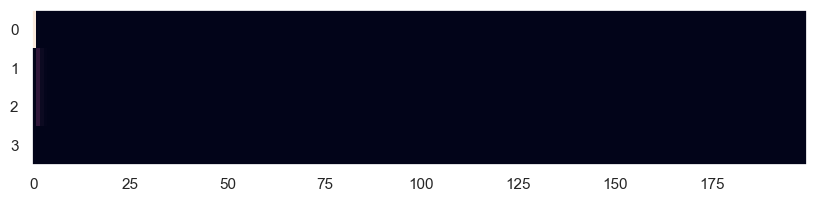

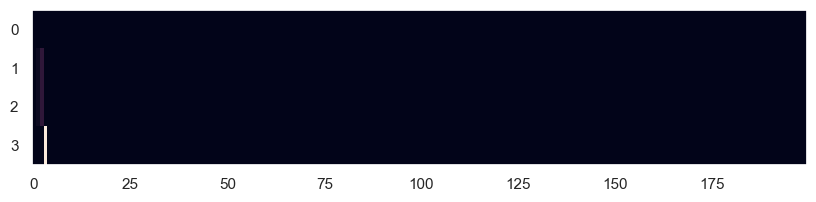

In [8]:
class State(IntEnum):
    Start = 0
    TranscriptionFactor = 1,
    NonTranscriptionFactor = 2,
    End = 3

def calculate_emission_prob(sequence: list[Base]):
    """
    Calculate alpha -> beta base probability
    :param sequence: Genome
    :return: Probabilities
    """
    count_matrix = np.zeros((4, 4))
    count_bases = np.zeros(4)
    for i in range(len(sequence)):
        count_matrix[sequence[i], sequence[i+1]] += 1
        count_bases[sequence[i]] += 1

    for i in range(4):
        count_matrix[i, :] /= count_bases[i]

    return count_matrix


def transition_prob(cur: State, dest: State) -> float:
    return 0.5

def emission_prob(state: State, base: Base) -> float:
    return 0.25

def forwards(sequence: list[Base]) -> np.array:
    length = len(sequence)
    paths = np.zeros((4, length))

    # Initialize starting state
    paths[0, State.Start] = 1

    # Iterative calculation instead of recursion
    # i is the current base position
    for i in range(length):
        # $f_k(i) = e_k(x_i) \sum_l (f_l(i-1) a_{lk})$
        paths[State.TranscriptionFactor, i] = (
                emission_prob(State.TranscriptionFactor, sequence[i])
                *
                sum([prob * transition_prob(j, State.TranscriptionFactor) for (j, prob) in enumerate(paths[:, i - 1])])
        )
        paths[State.NonTranscriptionFactor, i] = (
                emission_prob(State.NonTranscriptionFactor, sequence[i])
                *
                sum([prob * transition_prob(j, State.NonTranscriptionFactor) for (j, prob) in enumerate(paths[:, i - 1])])
        )

    return paths


def backwards(sequence: list[Base]) -> np.array:
    length = len(sequence)
    paths = np.zeros((4, length))

    # Initialize ending state
    paths[-1, State.End] = 1

    # Iterative calculation instead of recursion
    # i is the current base position
    for i in range(length - 2, 0, -1):
        # $b_k(i) = \sum_{l} b_l(i+1)e_l(x_{i+1})a_{kl}$
        paths[State.TranscriptionFactor, i] = sum(
            [prob * emission_prob(j, sequence[i + 1]) * transition_prob(j, State.TranscriptionFactor) for (j, prob) in enumerate(paths[:, i + 1])]
        )

        paths[State.NonTranscriptionFactor, i] = sum(
            [prob * emission_prob(j, sequence[i + 1]) * transition_prob(j, State.NonTranscriptionFactor) for (j, prob) in enumerate(paths[:, i + 1])]
        )

    return paths

forward = forwards(promoter_sequence)
backward = backwards(promoter_sequence)

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 5))
ax1.imshow(forward)
ax1.grid(False)
fig1.gca().set_aspect(10)
plt.show()

fig2, ax2 = plt.subplots(1, 1, figsize=(10, 5))
ax2.imshow(backward)
ax2.grid(False)
fig2.gca().set_aspect(10)
plt.show()


In [73]:
class SegmentationModel:
    R: list[float]
    R_prime = list[float]
    G: list[float]
    sequence: str
    probabilities = dict[list[Base], float]

    def __init__(self, sequence: str):
        self.sequence = sequence
        self.R = []
        self.R_prime = []
        self.G = []
        self.probabilities = {}

        # Get initial base probability
        length = len(sequence)
        for base in sequence:
            if base in self.probabilities.keys():
                self.probabilities[base] += 1
            else:
                self.probabilities[base] = 1
        for key in self.probabilities.keys():
            self.probabilities[key] /= length

    def delta(self, one: str, other: str) -> int:
        return int(one == other)

    def calc_forward(self, i: int) -> float:
        keys = self.probabilities.keys()
        p_alpha = 0
        if self.sequence[i] in keys:
            p_alpha = self.probabilities[self.sequence[i]]

        p_alpha_sum = 0
        l_max = max(map(lambda x: len(x), keys))
        for l in range(2, l_max + 1):
            sub_seq = self.sequence[i - l : i]
            if sub_seq in keys:
                r_prod = 1
                for k in range(i - l + 1, i):
                    r_prod *= self.R[k]
                p_alpha_sum += self.probabilities[sub_seq] * (1 / r_prod)
        return p_alpha + p_alpha_sum

    def calc_backward(self, i: int) -> float:
        keys = self.probabilities.keys()
        p_alpha = 0
        if self.sequence[i] in keys:
            p_alpha = self.probabilities[self.sequence[i]]

        p_alpha_sum = 0
        l_max = max(map(lambda x: len(x), keys))

        for l in range(2, l_max + 1):
            sub_seq = self.sequence[i + l - 1 : l]
            if sub_seq in keys:
                r_prod = 1
                for k in range(i + 1, i + l):
                    r_prod *= self.R_prime[k]
                p_alpha_sum += self.probabilities[sub_seq] * (1 / r_prod)
        return p_alpha + p_alpha_sum

    def calc_G(self, i: int, l: int) -> float:
        ratio = 1
        for k in range(1, i - l + 1):
            ratio *= self.R[k] / self.R_prime[k]

        denom = 1
        for k in range(i - l + 1, i + 1):
            denom *= 1 / self.R_prime[k]

        return ratio * denom

    def calc_z_score(self) -> list[float]:
        for i in range(len(self.sequence)):
            self.R.append(self.calc_forward(i))
            self.R_prime.append(self.calc_backward(i))

        keys = self.probabilities.keys()
        Z = []
        for alpha in keys:
            for beta in keys:
                # N_ab calculation
                G_sum = 0
                for i in range(len(self.sequence)):
                    a_length = len(alpha)
                    b_length = len(beta)
                    G_sum += (
                            self.calc_G(i, a_length + b_length)
                            * self.delta(alpha, self.sequence[i - b_length : i - b_length + a_length])
                            * self.delta(beta, self.sequence[i: i + b_length])
                              )
                # <l> calculation
                l = 0
                for key in keys:
                    l += len(key) * self.probabilities[key]

                N_av = len(self.sequence) / l

                N_ab = self.probabilities[alpha] * self.probabilities[beta] * G_sum

                Z_ab = N_ab - N_av * self.probabilities[alpha] * self.probabilities[beta] / np.sqrt(N_av * self.probabilities[alpha] * self.probabilities[beta])
                Z.append((alpha, beta, Z_ab))
        return Z

In [74]:


def alg(sequence: str):
    SM = SegmentationModel(sequence)
    for i in range(len(sequence)):
        print(f"{SM.R == SM.R_prime}")
        Z = SM.calc_z_score()
        print(sorted(Z, key=lambda x: x[2], reverse=True))
        break
        # R and R' should be equal (forwards and backwards) =>  CHECK

print(promoter_sequence)

GACTAGATGCCGTTTTTTGTGGGACTTGCCAGCTGAGCAGTTACCTTGCGAGTATTGGCTCCCCACTTGTTGCCAGTTACTAAATCCGACCTTGTGTCTCAAGGGTACGTTCCGGATATAGGTGCTAATTGTAGAGAACAGTTTGTAGTCCAGCAGAAACTAGCTCAACAAGACGAGCGCGCACGTTTCTGAGCCACCCC


In [75]:
alg(promoter_sequence)

True
[('T', 'T', np.float64(15.181623381592637)), ('A', 'G', np.float64(14.608835008437365)), ('G', 'T', np.float64(12.32576538582523)), ('C', 'C', np.float64(11.464466094067262)), ('T', 'G', np.float64(11.325765385825232)), ('G', 'C', np.float64(10.464466094067262)), ('G', 'A', np.float64(9.608835008437369)), ('A', 'C', np.float64(9.608835008437369)), ('C', 'T', np.float64(9.325765385825232)), ('C', 'A', np.float64(8.608835008437369)), ('T', 'A', np.float64(8.475797962658781)), ('A', 'A', np.float64(5.747308806541881)), ('C', 'G', np.float64(5.464466094067262)), ('T', 'C', np.float64(4.325765385825232)), ('G', 'G', np.float64(3.4644660940672627)), ('A', 'T', np.float64(2.4757979626587803))]
